In [ ]:
from minisom import MiniSom
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import cv2
from tensorflow.keras.models import load_model
from detection_XAI.utils import utils

In [ ]:
# Load the features by SSL
path = "./data/features/reshaped_features.npy"
reshaped_features = np.load(path)

# labells
y_cluster = io.loadmat('./SSL/data/y_cluster.mat')
y_cluster = y_cluster['y_cluster']

#one-coding for labels
from keras.utils import to_categorical
y_cluster_n = to_categorical(y_cluster-1)

In [ ]:
#SOM parameters setting
data = reshaped_features
som_shape = (17, 17)
n_size = som_shape[1]
som = MiniSom(som_shape[0], som_shape[1], input_len=data.shape[1], sigma=2.8, learning_rate=0.5, neighborhood_function='gaussian', random_seed=0)
#8x8:1.5 12x12:2 17x17:2.6 20x20:3.3
#Neighborhood_function = 'gaussian'、'mexican_hat'、'bubble'.

#SOM training
som.pca_weights_init(data)
som.train_random(data, num_iteration=2000)

/usr/local/lib/python3.10/dist-packages/minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


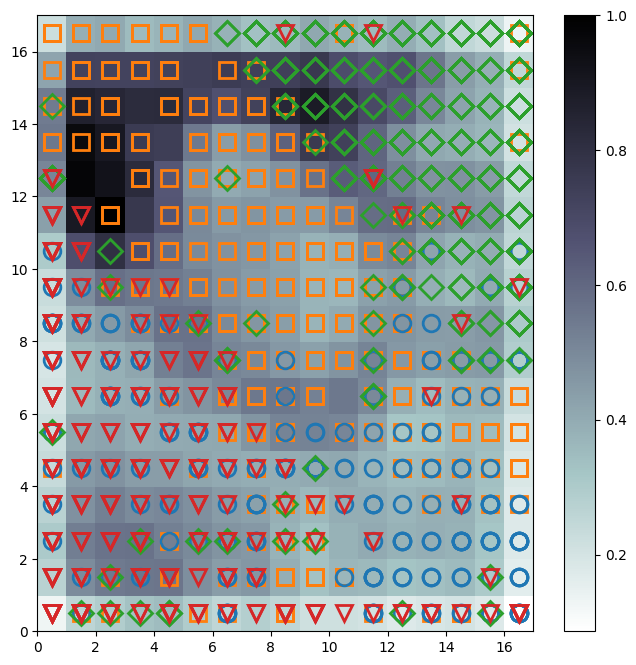

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
target = y_cluster.flatten()
plt.figure(figsize=(8, 8))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['o', 's', 'D','v']
colors = ['C0', 'C1', 'C2', 'C3']
for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[int(target[cnt]-1)], markerfacecolor='None',
             markeredgecolor=colors[int(target[cnt]-1)], markersize=12, markeredgewidth=2)

plt.show()

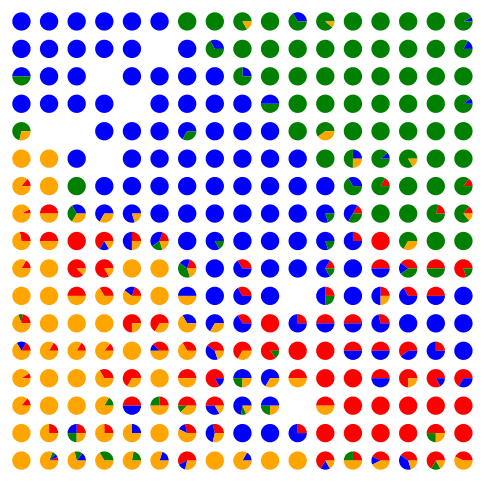

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

n_neurons = n_size
m_neurons = n_size
label_names = {1: 'Quake', 2: 'Earthquake', 3: 'Rockfall', 4: 'N/A noise'}
label_colors = {'Quake': 'red', 'Earthquake': 'blue', 'Rockfall': 'green', 'N/A noise': 'orange'}
labels_map = som.labels_map(data, [label_names[t] for t in target])

fig = plt.figure(figsize=(6, 6))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    colors = [label_colors[l] for l in label_names.values()]
    plt.subplot(the_grid[n_neurons - 1 - position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs, colors=colors)

#plt.legend(patches, label_names.values(), loc='upper right')
plt.show()

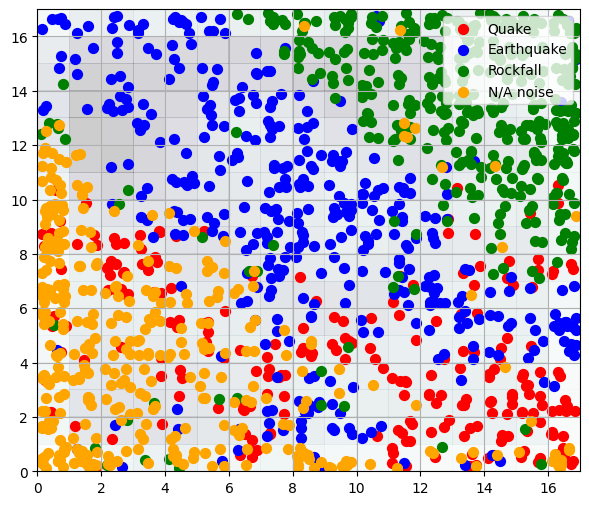

In [ ]:
w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(7, 6))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
#plt.colorbar()

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                s=50, c=colors[int(c-1)], label=label_names[int(c)])
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [ ]:
# results from real label
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
def classify(som,data,winmap):
    from numpy import sum as npsum
    default_class = npsum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

winmap = som.labels_map(data,target)
y_pred = classify(som,data,winmap)
target_name = ['quake','earthquake','rockfall','enviroemnt noise']
print(classification_report(target, np.array(y_pred),target_names=target_name,digits=4))
print(confusion_matrix(target, np.array(y_pred)))

                  precision    recall  f1-score   support

           quake     0.7668    0.7308    0.7484       234
      earthquake     0.8985    0.9100    0.9042       389
        rockfall     0.9347    0.9254    0.9300       402
enviroemnt noise     0.8417    0.8657    0.8535       350

        accuracy                         0.8727      1375
       macro avg     0.8604    0.8580    0.8590      1375
    weighted avg     0.8722    0.8727    0.8723      1375

[[171  20   4  39]
 [ 16 354  10   9]
 [  7  14 372   9]
 [ 29   6  12 303]]


In [ ]:
#for saving SOM model
import pickle

path_to_save = 'som_17x17.pkl'
with open(path_to_save, 'wb') as f:
    pickle.dump(som, f)

with open('path_to_save', 'rb') as f:
    loaded_som = pickle.load(f)